# Dependencies

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from pprint import pprint
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Data Prep

In [2]:
# Import data
train_df = pd.read_csv(Path('Resources/2019loans.csv'))
test_df = pd.read_csv(Path('Resources/2020Q1loans.csv'))

In [3]:
# Check for any missing features between the train and test data
a = train_df.columns.to_list()
b = test_df.columns.to_list()
for i in a:
    are_missing_features = False
    if i not in b:
        print(i)
        are_missing_features = True
if are_missing_features == False:
    print("No missing features.")

No missing features.


In [4]:
# Save # of rows in data
train_rows = len(train_df.index)
test_rows = len(train_df.index)

# Drop any null or na values
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

# Check the number of drops
print(f'''
Train data had {train_rows} rows, dropped {train_rows - len(train_df.index)}, now {len(train_df.index)}.
Test data had {train_rows} rows, dropped {test_rows - len(test_df.index)}, now {len(test_df.index)}.
''')


Train data had 12180 rows, dropped 0, now 12180.
Test data had 12180 rows, dropped 7478, now 4702.



In [5]:
# Drop unnecessary columns
train_df.drop('Unnamed: 0', axis=1, inplace=True)
test_df.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
# Separate target feature for training data
train_data = train_df.drop('loan_status', axis=1)
train_target = train_df['loan_status']

# Convert categorical to numeric (one hot encoding, label encoding)
train_encoded_data = pd.get_dummies(train_data)
train_target = LabelEncoder().fit_transform(train_target)

In [7]:
# Separate target feature for testing data
test_data = test_df.drop('loan_status', axis=1)
test_target = test_df['loan_status']

# Convert categorical to numeric (one hot encoding, label encoding)
test_encoded_data = pd.get_dummies(test_data)
test_target = LabelEncoder().fit_transform(test_target)

In [8]:
# Checking shapes of data
print(f'''
Train X shape: {train_encoded_data.shape}
Train y shape: {train_target.shape}
Test X shape: {test_encoded_data.shape}
Test y shape: {test_target.shape}
''')


Train X shape: (12180, 93)
Train y shape: (12180,)
Test X shape: (4702, 92)
Test y shape: (4702,)



In [9]:
# Finding the feature column
a = train_encoded_data.columns.to_list()
b = test_encoded_data.columns.to_list()
for i in a:
    are_missing_features = False
    if i not in b:
        print(i)
        are_missing_features = True
if are_missing_features == False:
    print("No missing features.")

debt_settlement_flag_Y


In [10]:
# Dropping that column
train_encoded_data.drop('debt_settlement_flag_Y', axis=1, inplace=True)

# ML Modeling

### Note

I predict that the **random forest classifier** will be the better model overall because:
- random forest is a model ensemble, which allows for greater amounts of testing
- random forest also allows for feature selection, which itself
    - reduces likelihood of overfitting
    - makes it easier to visualize and interpret

In [11]:
# Check unscaled model score (Logistic Regression model)
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(train_encoded_data, train_target)
log1 = log_reg_model.score(test_encoded_data, test_target)
log1

C:\Users\Chrismus Time\anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5831561037856231

In [12]:
# Check unscaled model score (Random Forest Classifier model)
rand_forest_model = RandomForestClassifier(random_state=1, n_estimators=50)
rand_forest_model.fit(train_encoded_data, train_target)
rand1 = rand_forest_model.score(test_encoded_data, test_target)
rand1

0.6720544449170566

### Note

I predict that standardizing the scale will improve the prediction strength of both the models because our predictions will now be more accurate. The data utilizes different units and has a large range, meaning the weight given to scores that are at the upper percentile of the range will too large. Standardization will equalize the data variability.

Ultimately, if both models are improving, and random forest is higher in performance already, **random forest** will continue to be the better model after scaling.

In [13]:
# Scale the data
# decide to standard scaler because I am assuming the loan metrics fall on a normal distribution
scaler = StandardScaler()
train_encoded_scaled = scaler.fit_transform(train_encoded_data)
test_encoded_scaled = scaler.fit_transform(test_encoded_data)

In [14]:
# Check scaled model score (Logistic Regression model)
log_reg_model.fit(train_encoded_scaled, train_target)
log2 = log_reg_model.score(test_encoded_scaled, test_target)
log2

0.6695023394300298

In [15]:
# Check scaled model score (Random Forest Classifier model)
rand_forest_model.fit(train_encoded_scaled, train_target)
rand2 = rand_forest_model.score(test_encoded_scaled, test_target)
rand2

0.5606125053168864

In [16]:
print(f'''
Logistic regression model scaled is {round(log2,2)}, {round(log2-log1,2)} off of unscaled {round(log1,2)}.
Random forest model score scaled is {round(rand2,2)}, {round(rand2-rand1,2)} off of unscaled {round(rand1,2)}
''')


Logistic regression model scaled is 0.67, 0.09 off of unscaled 0.58.
Random forest model score scaled is 0.56, -0.11 off of unscaled 0.67



### Note

Unscaled:
Random forest model performed better than the logistic regression model, as predicted.

Scaled:
It seems like with scaled data, the random forest model performs worse. While unsure, my guess is that due to the way random forest is sampled, its possible that the majority of the randomly sampled data got drastically/disproportionately changed with the scaling, resulting in an unfortunate decrease in performance.

Ultimately, both models in either case are rather weak. There a number of potential improvements moving forward: hyperparameter tuning, different classifier models, and/or different features to test on.

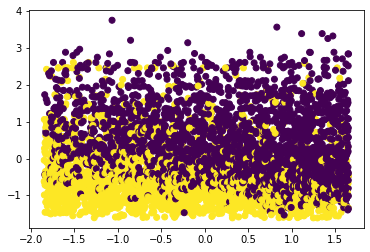

In [17]:
import matplotlib.pyplot as plt
labels = log_reg_model.predict(test_encoded_scaled)
plt.scatter(test_encoded_scaled[:,0], test_encoded_scaled[:,3], c=labels)

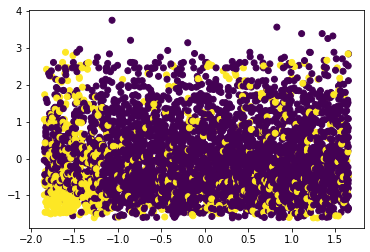

In [18]:
labels = rand_forest_model.predict(test_encoded_scaled)
plt.scatter(test_encoded_scaled[:,0], test_encoded_scaled[:,3], c=labels)